# Code to run and plot PCA

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-233.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [2]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pop_list=[""], iid_col="iid", exact=False, output=True):
    """Remove indivdiuals from PCA dataframe"""
    if exact:
        idx = df[iid_col].isin(pop_list) 
    else:
        pops = "|".join(pop_list)
        idx = df[iid_col].str.contains(pops)

    df = df[idx].copy()
    if output:
        print(f"Matching IIDs: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    pops = "|".join(pop_list)
    idx = df[pop_col].str.contains(pops)
    df = df[idx].copy()
    print(f"{pops} Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

def split_up_df(df, col="loc"):
    """Split up Dataframe by column.
    Return column labels and dataframes"""
    locs = [l for l, _ in df.groupby(col)]
    dfs = [df for _, df in df.groupby(col)]
    return locs, dfs

####################################################
### Plotting PCA

def plot_pca(ax, df, c="gray", alpha=1.0, legend="", marker="o",
             s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt, (x[i], y[i]), ha="left", va="bottom", c=c)
            
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")   
            
###########################################################
### Helper Functions

def return_pca_matches(df, iid="I22119",
                       pcs = ["pc1", "pc2", "pc3", "pc4"]):
    """Return matches in pc space to sample iid.
    Report sorted dataframe"""
    pc_t = df[df["iid"]==iid][pcs]
    diffs = df[pcs]-pc_t.values
    diff_sq = np.sum(diffs**2,axis=1)
    idx = diff_sq.sort_values().index
    return df.iloc[idx,:].copy()

In [3]:
min_snp = 20000
path_pca = "./output/pca/v54.1/20230602.punic.v54.1_HO2.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v54.1.anno.csv"
savepath="./output/pca/v54.1/pcs_meta.tsv"


df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "clst"]]
df = pd.merge(df, df2, on="iid", how="left")
df["clst"].fillna(inplace = True, value="missing") # Fill NaNs

idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

idx = df["iid"]=="I22257" # The Sudan Outlier
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")
#df[df["pop"].str.contains("Lebanon")]

if len(savepath)>0:
    #df.to_csv(savepath, sep="\t", index=False)
    print(f"Saved {len(df)} Indivduals with PCs to {savepath}")

Filtering to 2663/2690
Filtered to 2620 Individuals based on Min SNP: 20000
Filtered to 2532 based on duplicates
Filtered to 2531 based on manual removals
Saved 2531 Indivduals with PCs to ./output/pca/v54.1/pcs_meta.tsv


### Get PCA populations

In [4]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
df_is = get_sub_pops_exact(df, pop_list=["Israel_MLBA"])
df_is_o = get_sub_pops_exact(df, pop_list=["Israel_MLBA_o"])

df_le = get_sub_pops_exact(df, pop_list=["Lebanon_MBA.SG"])
#df_isp = get_sub_pops_exact(df, pop_list=["Israel_Phoenician"])
df_isp = get_sub_pops(df, pop_list=["Israel_Phoenician"], pop_col="clst")

df_sard = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])
df_sard_ba = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_EBA","Italy_Sardinia_BA_Nuragic"])

df_tun = get_sub_pops(df, pop_list=["Tunisia_N", "Tunisia_Mesolithic", "Tunisia_LN"], pop_col="clst")
df_gua = get_sub_pops(df, pop_list=["Guanche"])

df_vil = get_sub_iid(df, ["VIL"])
df_msr = get_sub_iid(df, ["MSR"])

df_greek = get_sub_pops_exact(df, pop_list=["Greece_BA_Mycenaean"])
df_alg = get_sub_pops(df, pop_list=["Algeria_IA"], pop_col="clst")
df_spain = get_sub_pops_exact(df, pop_list=["Spain_IA"])

df_sic_mba = get_sub_pops_exact(df, pop_list=["Italy_Sicily_MBA"])

df_vill = get_sub_pops(df, pop_list=["Villaricos"], pop_col="loc")
df_vill = df_vill[(df_vill["clst"].str.contains("Punic")) & (df_vill["age"]>2000)]
df_ib = get_sub_pops(df, ["Ibiza_Punic"])
#df_sic = get_sub_pops_exact(df, ["Italy_Phoenician_Sicily"])
df_sic2 = get_sub_pops(df, ["Italy_Sicily_Punic"])
df_mar = df_sic2[df_sic2["loc"].str.contains("Marsala")].copy()
df_mot = df_sic2[df_sic2["loc"].str.contains("Motya")].copy()
df_bir = df_sic2[df_sic2["loc"].str.contains("Birgi")].copy()
df_sel = df_sic2[df_sic2["loc"].str.contains("Selinunte")].copy()
df_pal = df_sic2[df_sic2["loc"].str.contains("Palermo")].copy()

df_carth = get_sub_pops(df, pop_list=["Carthage"], pop_col="loc")
df_carth = df_carth[df_carth["clst"].str.contains("Punic")]
df_capbon = get_sub_pops(df, pop_list=["Cap Bon"], pop_col="loc")

dft = get_sub_pops(df, ["Spain_Punic"])
df_cad = get_sub_pops(df, pop_list=["Cádiz"], pop_col="loc")

df_sic_ia = get_sub_pops_exact(df, ["Italy_Sicily_IA_Polizzello"])
df_sic_him = get_sub_pops(df, ["Sicily_Himera"])

df_eg_hell = get_sub_pops(df, ["Egypt_Hellenistic"])
df_eg_dyn = get_sub_pops(df, ["Egypt_Dynastic"])
df_eg_third = get_sub_pops(df, ["Egypt_ThirdIntermediate"])
df_meno = get_sub_pops(df, ["Menorca"])
df_kerk = get_sub_pops(df, ["Kerkouene"], pop_col="loc")

Found ['construct_WE_NA_PCA'] (exact): 1196/2531
Found ['Israel_MLBA'] (exact): 35/2531
Found ['Israel_MLBA_o'] (exact): 1/2531
Found ['Lebanon_MBA.SG'] (exact): 5/2531
Israel_Phoenician Found: 13/2531
Italy_Sardinia_Punic Found: 1/2531
Found ['Italy_Sardinia_EBA', 'Italy_Sardinia_BA_Nuragic'] (exact): 23/2531
Tunisia_N|Tunisia_Mesolithic|Tunisia_LN Found: 7/2531
Guanche Found: 5/2531
Matching IIDs: 6/2531
Matching IIDs: 2/2531
Found ['Greece_BA_Mycenaean'] (exact): 12/2531
Algeria_IA Found: 1/2531
Found ['Spain_IA'] (exact): 18/2531
Found ['Italy_Sicily_MBA'] (exact): 0/2531
Villaricos Found: 16/2531
Ibiza_Punic Found: 1/2531
Italy_Sicily_Punic Found: 1/2531
Carthage Found: 21/2531
Cap Bon Found: 8/2531
Spain_Punic Found: 4/2531
Cádiz Found: 4/2531
Found ['Italy_Sicily_IA_Polizzello'] (exact): 19/2531
Sicily_Himera Found: 36/2531
Egypt_Hellenistic Found: 3/2531
Egypt_Dynastic Found: 2/2531
Egypt_ThirdIntermediate Found: 2/2531
Menorca Found: 5/2531
Kerkouene Found: 27/2531


In [ ]:
df_cad = get_sub_pops(df, pop_list=["Cádiz"], pop_col="loc")

In [ ]:
dft = get_sub_pops(df, ["MA89"], pop_col="iid")
dft

### HO PCA shrinkmode YES outlierremoval NO

Found ['construct_WE_NA_PCA'] (exact): 1196/2531


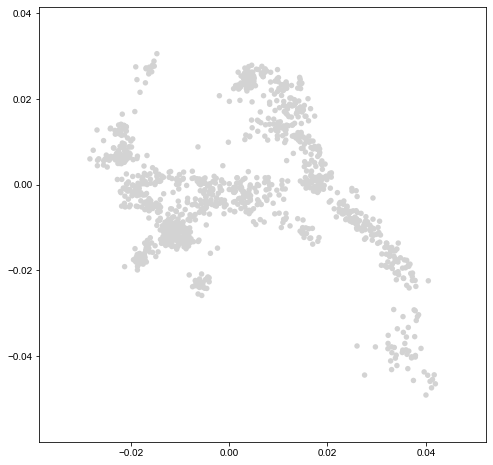

In [7]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot full PCA

I4800|I22232|I22236|I4798|I4799 IIDs: 5/2531
I12844 IIDs: 1/2531
I8577|I7454 IIDs: 2/2531
I12849|I7265 IIDs: 2/2531


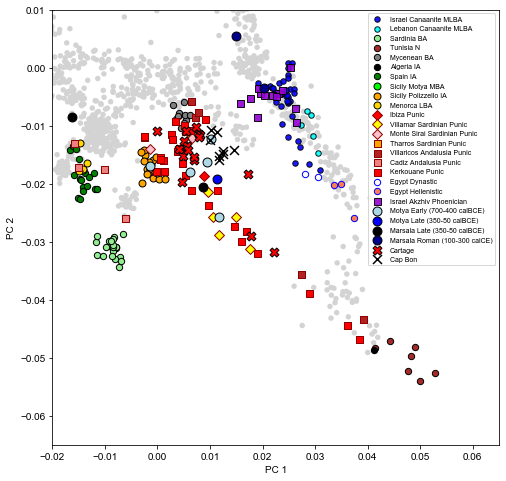

In [5]:
savepath="./figures/pca.v51.1/full_pca.pdf"
savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)

### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")

plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")

plot_pca(ax, df_isp, c="darkviolet", legend="Israel Akzhiv Phoenician", ec="k", s=49, marker="s", alpha=0.9)

df_iid = get_sub_iid(df, ["I4800", "I22232", "I22236", "I4798", "I4799"])
plot_pca(ax, df_iid, c="lightblue", legend="Motya Early (700-400 calBCE)", ec="k", s=80, marker="o")

df_iid = get_sub_iid(df, ["I12844"])
plot_pca(ax, df_iid, c="blue", legend="Motya Late (350-50 calBCE)", ec="k", s=80, marker="o")

df_iid = get_sub_iid(df, ["I8577|I7454"])
plot_pca(ax, df_iid, c="black", legend="Marsala Late (350-50 calBCE)", ec="k", s=80, marker="o")

df_iid = get_sub_iid(df, ["I12849|I7265"])
plot_pca(ax, df_iid, c="darkblue", legend="Marsala Roman (100-300 calCE)", ec="k", s=80, marker="o")

#df_iid = get_sub_iid(df, ["I12849|I7265"])
plot_pca(ax, df_carth, c="red", legend="Cartage", ec="k", s=80, marker="X")
plot_pca(ax, df_capbon, c="orange", legend="Cap Bon", ec="k", s=80, marker="x")



#df_iid = get_sub_iid(df, ["I21971"])
#plot_pca(ax, df_iid, c="gray", legend="Marsala Punic Context", ec="k", s=80, marker="o")

ax.legend(loc="upper right", fontsize=7)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
#ax.set_xlim([-0.035,0.085])
#ax.set_ylim([-0.07,0.034])

ax.set_xlim([-0.02,0.065])
ax.set_ylim([-0.065,0.01])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [10]:
df_mos = df_ho[df_ho["pop"].str.contains("Moz")]

In [11]:
df_mos

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,clst


# Plot Single Samples

In [5]:
def plot_pca_sample(iid, savepath="", show=True, xy=[], 
                    label="", only_context=True, exact=False):
    """Plot PCA of a single new individual"""
    #savepath=""

    plt.figure(figsize=(8,8))
    ax = plt.gca()

    plot_pca_ho(ax, df_ho, c="lightgray", text=False) # HO Reference
    
    plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
    plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
    plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
    plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
    plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)
    plot_pca(ax, df_gua, c="yellow", legend="Guanche Pre-Contact", s=40, ec="k")
    plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
    plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
    plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")
    plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")
    plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
    plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
    plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")
    plot_pca(ax, df_isp, c="darkviolet", legend="Israel Akzhiv Phoenician", ec="k", s=49, marker="s", alpha=0.9)
    plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
    
    
    if only_context:
        plot_pca(ax, df_sard, c="gray", legend="Var. Punic", ec="gray", s=49, marker="o", text=False, alpha=0.9)
        plot_pca(ax, df_vill, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
        plot_pca(ax, df_cad, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
        #plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
        
    else:
        #plot_pca(ax, df_kerk, c="rosybrown", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
        plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")
        plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
        plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")
        plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)
        plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
        plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

    df_iid = get_sub_iid(df, iid, exact=exact)
    
    if len(label)==0:
        label=iid[0]
    plot_pca(ax, df_iid, c="red", legend=label, ec="k", s=120, marker="X")

    ax.legend(loc="upper right", fontsize=9)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_xlim([-0.035,0.085])
    ax.set_ylim([-0.07,0.034])
    
    if len(xy)>0:
        iid = df_iid["iid"].values[0]
        depth, age = df_iid["n_cov_snp"].values[0].astype("int"), df_iid["age"].values[0].astype("int")
        text = f"{iid}:\n{depth:.0f} SNPs\n{age:.0f} BP"
        ax.text(xy[0], xy[1], text, ha='left', va='bottom', transform=ax.transAxes)
    
    if len(savepath) > 0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=600)
        print(f"Saved to: {savepath}")
    if show:
        plt.show()
    else:
        plt.close()

### Run single individual on PCA

In [22]:
df[df["iid"].str.contains("I22094")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact,clst
1135,I22094,-0.008752,-0.020692,-0.001548,-0.010571,include,I22094,"Sardinia, Tharros",42981.0,0.035818,M,2350.0,"Luiselli, Donata",Italy_Sardinia_Punic_Late_oNAfrica


Matching IIDs: 0/2531
Saved to: ./figures/tharros_noC14.pdf


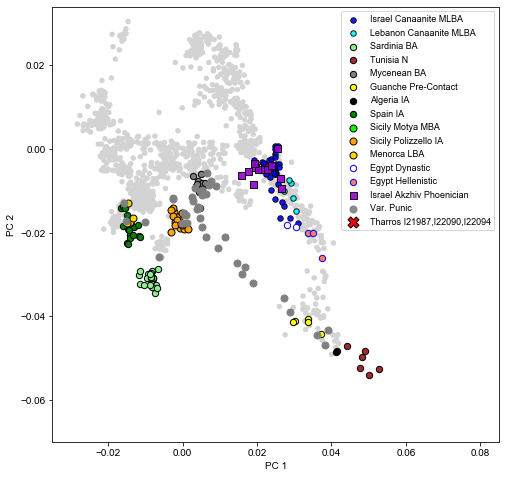

In [23]:
iids = ["I21963"] 

plot_pca_sample(iid=iids, label="Tharros I21987,I22090,I22094", 
                savepath="./figures/tharros_noC14.pdf", exact=True) 

Matching IIDs: 10/2531
Saved to: ./figures/pca_spain_eba.pdf


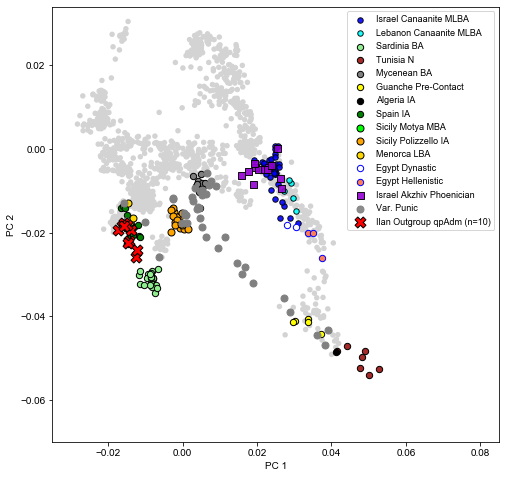

In [38]:
iids = ["I3997_noUDG", "I4561","I4560","I4562.SG","I3494",
        "I6470.SG","I1840","I3756","I8136", "VAD001"] 

plot_pca_sample(iid=iids, label="Ilan Outgroup qpAdm (n=10)", 
                savepath="./figures/pca_spain_eba.pdf", exact=True) 

In [ ]:
for iid in iids:
    plot_pca_sample(iid=[iid], label=iid, savepath="") 

I21854 IIDs: 1/2423


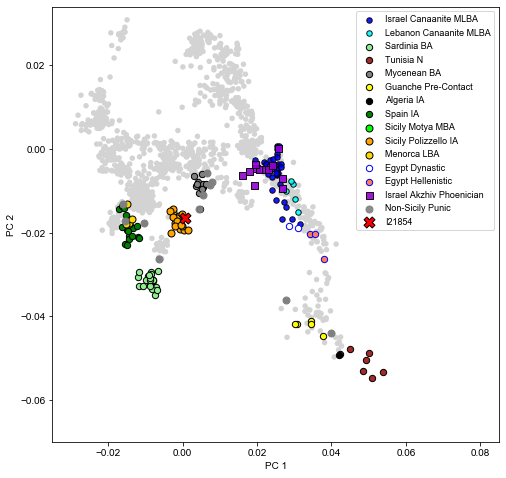

In [16]:
plot_pca_sample(iid=["I21854"], label="", savepath="") 

Matching IIDs: 1/2531


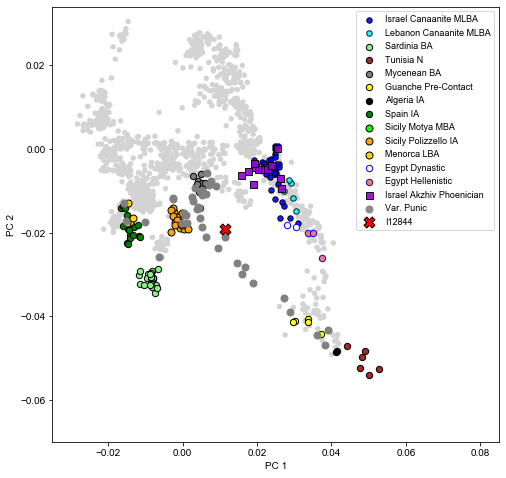

In [7]:
plot_pca_sample(iid=["I12844"], label="", savepath="") 

I22120 IIDs: 0/2286


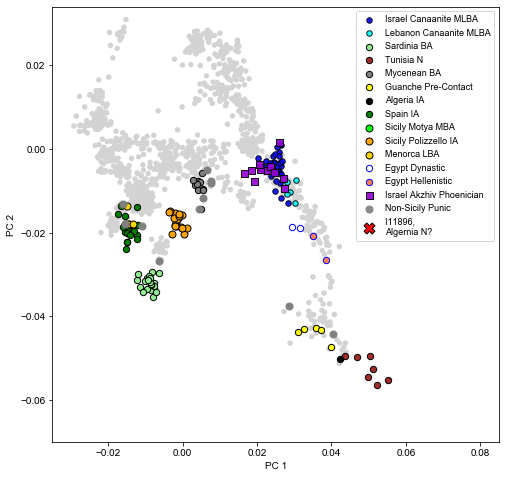

In [7]:
plot_pca_sample(iid=["I22120"], label="I11896, \nAlgernia N?", savepath="") # Caramelli Phoenician: I22232 I22235 I22236

In [ ]:
plot_pca_sample(iid=["I22237"], label="I22237, \nSicily MBA Afr.", savepath="") # Caramelli Phoenician: I22232 I22235 I22236

#I24040
#I24494
#I24193
#I24194

HGDP01257|HGDP01253|HGDP01280|HGDP01282 IIDs: 4/2286


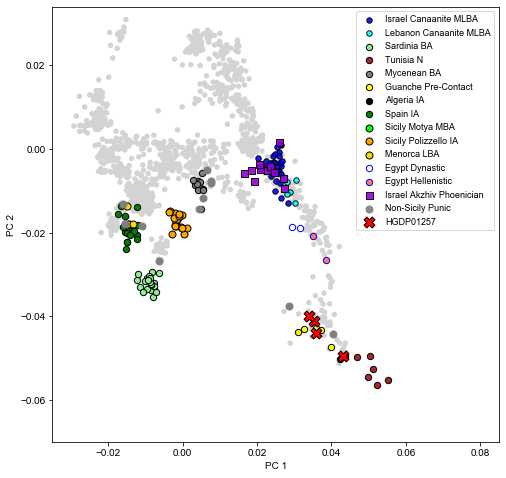

In [7]:
plot_pca_sample(iid=["HGDP01257", "HGDP01253", "HGDP01280", "HGDP01282"], label="", savepath="") # Caramelli Phoenician: I22232 I22235 I22236

#I24040
#I24494
#I24193
#I24194
#I24215

I24041|I24036|I24031 IIDs: 3/2286


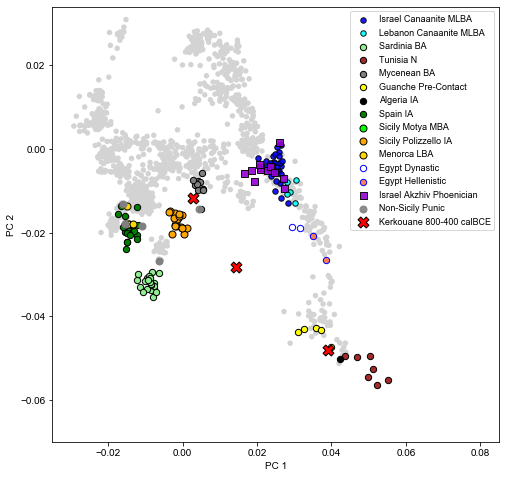

In [42]:
plot_pca_sample(iid=["I24041", "I24036", "I24031"], savepath="", label="Kerkouane 800-400 calBCE") 

I24213|I12847 IIDs: 2/2286


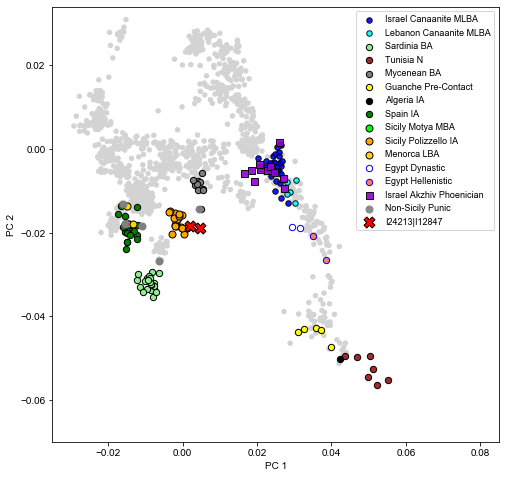

In [39]:
plot_pca_sample(iid=["I24213|I12847"], savepath="") # The Sicily-North Africa Sample

In [ ]:
df_isp.sort_values(by="pc1")

I22233_d|I22234|I22238|I22241|I22242|I22237 IIDs: 5/2094


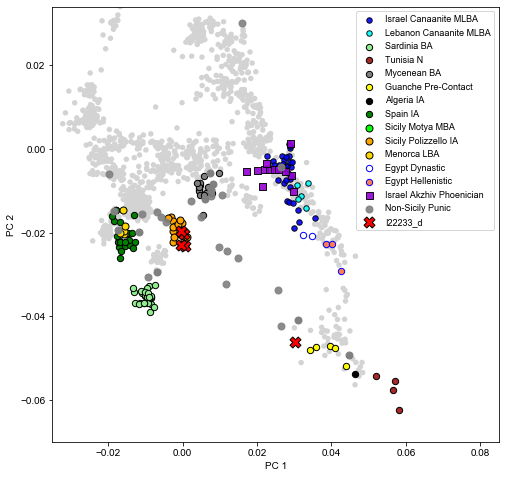

In [26]:
plot_pca_sample(iid=["I22233_d", "I22234", "I22238",
                    "I22241", "I22242", "I22237"], savepath="") # Caramelli Phoenician: I22232 I22235 I22236
#I19532

### Run multiple Individuals on PCA

I22115|I22121|I22118|I22096 IIDs: 4/2118


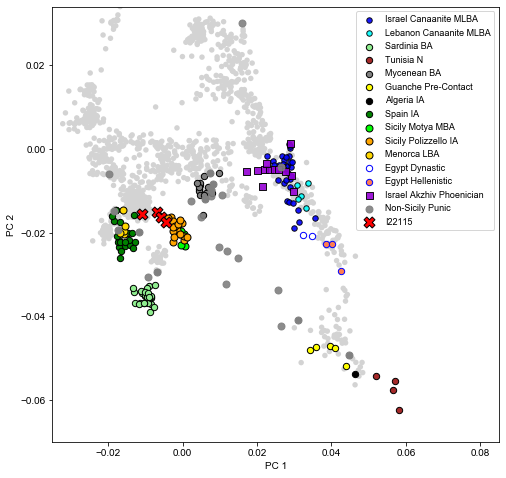

In [10]:
plot_pca_sample(iid=["I22115", "I22121", "I22118", "I22096"], savepath="") # Caramelli Phoenician: I22232 I22235 I22236

#I19532

I18193|I18189|I22093 IIDs: 3/2119
Saved to: ./figures/pca.v49.2/afr_end.png


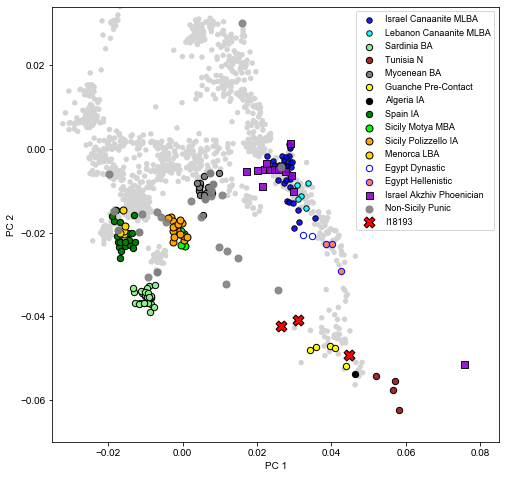

In [37]:
iids_afr_cline = ["I21966", "I21984", "I22094", "I22090", "VIL011", "VIL006", "VIL009", "VIL010", "VIL007"] # but not VIL004
#plot_pca_sample(iid=iids_afr_cline, savepath="./figures/pca.v46/afr_cline.png") # Caramelli Phoenician: I22232 I22235 I22236

iids_afr_punic =  ["I18193", "I18189", "I22093"]  # "I22113" high but not high enough
plot_pca_sample(iid=iids_afr_punic, savepath="./figures/pca.v49.2/afr_end.png")

# Sicily Early Punic [750-450 BCE]

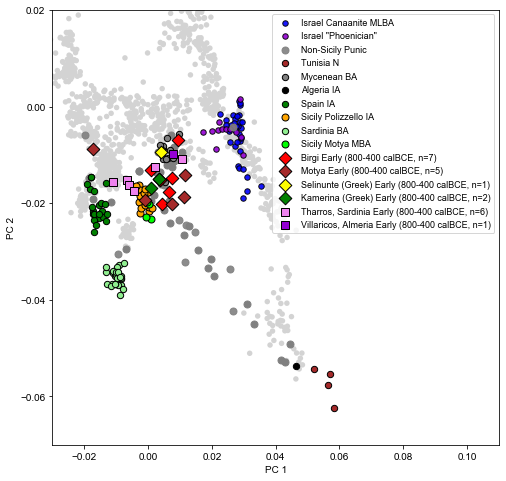

In [27]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath="./figures/pca.v49.2/hallstatt_plateau.pdf"
savepath=""


plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sard, c="gray", legend="Non-Sicily Punic", ec="gray", s=49, marker="o", text=False, alpha=0.9)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_cad, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)

plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)
plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")

### Plot the Re
df_iid = get_sub_iid(df, ["I12666|I12847|I24678|I24676|I24675|I24556|I22095"], output=False)
plot_pca(ax, df_iid, c="red", legend="Birgi Early (800-400 calBCE, n=7)", ec="k", s=80, marker="D")

df_iid = get_sub_iid(df, ["I4798|I4799|I4800|I7762|I22236"], output=False)
plot_pca(ax, df_iid, c="brown", legend="Motya Early (800-400 calBCE, n=5)", ec="k", s=80, marker="D")

df_iid = get_sub_iid(df, ["I21853"], output=False)
plot_pca(ax, df_iid, c="yellow", legend="Selinunte (Greek) Early (800-400 calBCE, n=1)", ec="k", s=80, marker="D")

df_iid = get_sub_iid(df, ["I14915", "I19532"], output=False)
plot_pca(ax, df_iid, c="green", legend="Kamerina (Greek) Early (800-400 calBCE, n=2)", ec="k", s=80, marker="D")

df_iid = get_sub_iid(df, ["I22115", "I22121", "I22096", 
                          "I22122", "I22118", "I22117"], output=False)
plot_pca(ax, df_iid, c="violet", legend="Tharros, Sardinia Early (800-400 calBCE, n=6)", ec="k", s=80, marker="s")

df_iid = get_sub_iid(df, ["I18201"], output=False)
plot_pca(ax, df_iid, c="darkviolet", legend="Villaricos, Almeria Early (800-400 calBCE, n=1)", ec="k", s=80, marker="s")


ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.03,0.11])
ax.set_ylim([-0.07,0.02])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Punic proper (450-200 BCE)

Saved to: ./figures/pca.v49.2/punic_proper.pdf


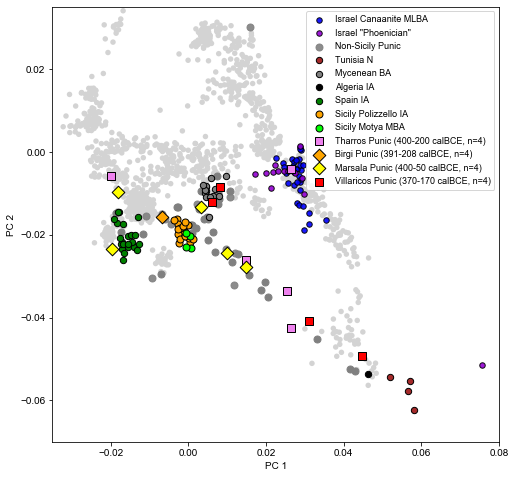

In [17]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
#savepath="./figures/pca.v46/tharros.pdf"
savepath="./figures/pca.v49.2/punic_proper.pdf"
#savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sard, c="gray", legend="Non-Sicily Punic", ec="gray", s=49, marker="o", text=False, alpha=0.9)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_cad, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)

plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)
plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")

plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")

### Plot the Re

df_iid = get_sub_iid(df, ["I22113|I22114|I22119|I21966|I22093"], output=False)
plot_pca(ax, df_iid, c="violet", legend="Tharros Punic (400-200 calBCE, n=4)", ec="k", s=80, marker="s")

df_iid = get_sub_iid(df, ["I24555"], output=False)
plot_pca(ax, df_iid, c="orange", legend="Birgi Punic (391-208 calBCE, n=4)", ec="k", s=80, marker="D")


df_iid = get_sub_iid(df, ["I7454|I8577|I21857|I12848|I21859"], output=False)
plot_pca(ax, df_iid, c="yellow", legend="Marsala Punic (400-50 calBCE, n=4)", ec="k", s=80, marker="D")

df_iid = get_sub_iid(df, ["I18193|I18189|I18199|I18203"], output=False)
plot_pca(ax, df_iid, c="red", legend="Villaricos Punic (370-170 calBCE, n=4)", ec="k", s=80, marker="s")

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot PCA of Sicily Roman (50-300 calCE)

I12664|I12849|I7265|I21970|I24680|I24557 IIDs: 6/2531


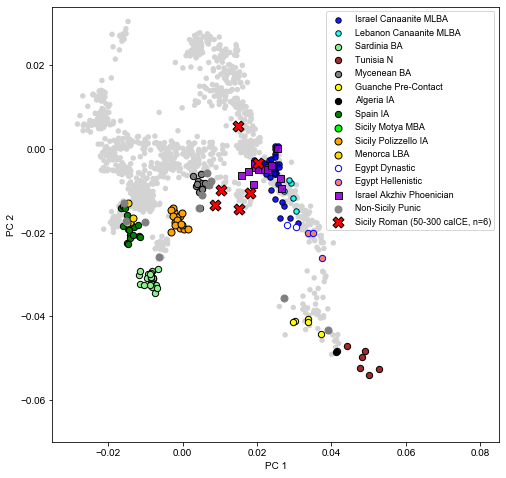

In [11]:
iids = ["I12664", "I12849", "I7265", "I21970", "I24680", "I24557"]
plot_pca_sample(iid=iids, label="Sicily Roman (50-300 calCE, n=6)",
               savepath="./figures/pca.v46.transect/roman.png") # Caramelli Phoenician: I22232 I22235 I22236

# Sicily Medieval [500-1200 CE]

I24560|I24553|I21852 IIDs: 3/2043
Saved to: ./figures/pca.v46.transect/medieval.png


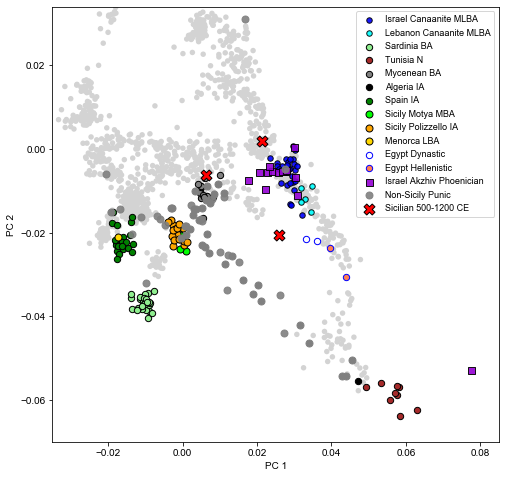

In [50]:
iids_young =  ["I24560", "I24553", "I21852"]  # "I22113" high but not high enough
plot_pca_sample(iid=iids_young, savepath="./figures/pca.v46.transect/medieval.png", label="Sicilian 500-1200 CE") # Caramelli Phoenician: I22232 I22235 I22236

# Sicily Late Medieval

In [ ]:
df_isp

I7764|I7765 IIDs: 2/2043
Saved to: ./figures/pca.v46.transect/medieval_late.png


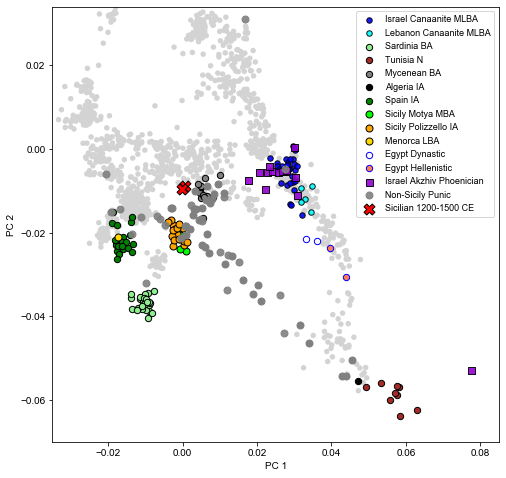

In [51]:
iids_young =  ["I7764", "I7765"]  # "I22113" high but not high enough
plot_pca_sample(iid=iids_young, savepath="./figures/pca.v46.transect/medieval_late.png", label="Sicilian 1200-1500 CE") # Caramelli Phoenician: I22232 I22235 I22236

### Plot and safe all Individual Punic Samples
Runs about 2 min for Sicily Sample

In [ ]:
#df_plot = get_sub_pops(df, ["Italy_Sicily_Roman"])
#df_plot = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])
df_vill = get_sub_pops(df, pop_list=["Villaricos"], pop_col="loc")
df_plot = df_vill[(df_vill["pop"].str.contains("Punic")) & (df_vill["age"]>2000)]


for iid in df_plot["iid"].values:
    savepath = f"/n/groups/reich/hringbauer/git/punic_aDNA/figures/pca.v46/villaricos_inds/{iid}.pdf"
    plot_pca_sample(iid=[iid], savepath=savepath, xy=[0.01,0.01], show=False) # Caramelli Phoenician: I22232 I22235 I22236

In [9]:
df_alg

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact
217,I12433,-0.047247,-0.055366,-0.055142,-0.054335,Algeria_IA,I12433,"Aurès, Constantine, Khenchela Cave",757025.0,0.630854,F,2752.0,"Pinhasi, Ron"


### Dated Motya Sample, context 6th century BCE, local Sicilian ancestry

In [8]:
plot_pca_sample(iid=["I12665|I21856|I24554|I22000"], savepath="") # Caramelli Phoenician: I22232 I22235 I22236

NameError: name 'plot_pca_sample' is not defined

### Plot single Ancient Individual

I22236 IIDs: 1/2286


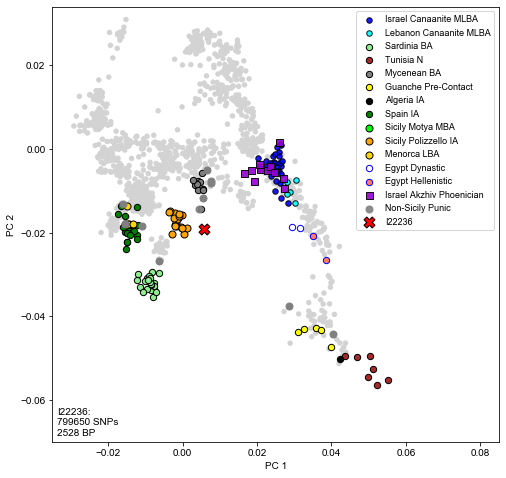

In [12]:
plot_pca_sample(iid=["I22236"], savepath="", xy=[0.01,0.01], label="") 

### Plot Series of Indivdiuals

In [ ]:
for iid in iids:
    plot_pca_sample(iid=[iid], savepath=f"./figures/pca.v51.1/kerk/{iid}.pdf", xy=[0.01,0.01], label="", show=False)

4
Saved to: ./figures/pca.v48.2/spain_inds.pdf


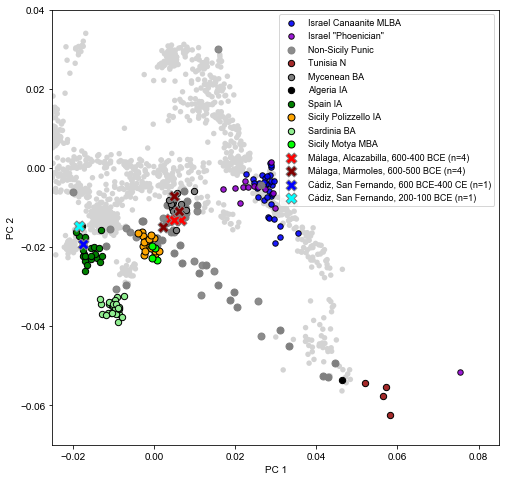

In [50]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
#savepath="./figures/pca.v46/tharros.pdf"
savepath="./figures/pca.v48.2/spain_inds.pdf"

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sard, c="gray", legend="Non-Sicily Punic", ec="gray", s=49, marker="o", text=False, alpha=0.9)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_cad, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)

plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)
plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")

### Plot the Re
df_iid = get_sub_iid(df, ["I26842.v47", "I26932.v47", "I26844", "I26915"], output=False)
print(len(df_iid))
plot_pca(ax, df_iid, c="red", legend="Málaga, Alcazabilla, 600-400 BCE (n=4)", 
         ec="gray", s=120, marker="X")

df_iid = get_sub_iid(df, ["I26931", "I26932", 
                          "I27075", "I27076"], output=False)
plot_pca(ax, df_iid, c="maroon", legend="Málaga, Mármoles, 600-500 BCE (n=4)", 
         ec="gray", s=120, marker="X")

df_iid = get_sub_iid(df, ["I8135"], output=False)
plot_pca(ax, df_iid, c="blue", legend="Cádiz, San Fernando, 600 BCE-400 CE (n=1)", 
         ec="gray", s=120, marker="X")

df_iid = get_sub_iid(df, ["I15434"], output=False)
plot_pca(ax, df_iid, c="cyan", legend="Cádiz, San Fernando, 200-100 BCE (n=1)", 
         ec="gray", s=120, marker="X")

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.085])
ax.set_ylim([-0.07,0.04])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

Saved to: ./figures/pca.v49.0/eivissa_inds.pdf


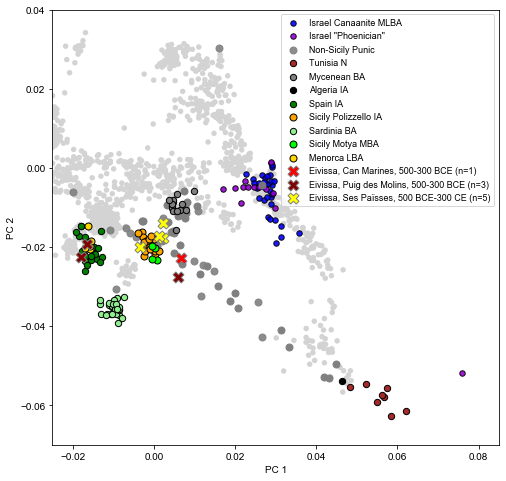

In [23]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
#savepath="./figures/pca.v46/tharros.pdf"
savepath="./figures/pca.v49.0/eivissa_inds.pdf"

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sard, c="gray", legend="Non-Sicily Punic", ec="gray", s=49, marker="o", text=False, alpha=0.9)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_cad, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)

plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)
plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")

plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)

### Plot the Re
df_iid = get_sub_iid(df, ["I27602"], output=False)
plot_pca(ax, df_iid, c="red", legend="Eivissa, Can Marines, 500-300 BCE (n=1)", 
         ec="gray", s=120, marker="X")

df_iid = get_sub_iid(df, ["I27619", "I27620","I27618"], output=False)
plot_pca(ax, df_iid, c="maroon", legend="Eivissa, Puig des Molins, 500-300 BCE (n=3)", 
         ec="gray", s=120, marker="X")

df_iid = get_sub_iid(df, ["I27610", "I27614",
                          "I27613", "I27617"], output=False)
plot_pca(ax, df_iid, c="yellow", legend="Eivissa, Ses Païsses, 500 BCE-300 CE (n=5)", 
         ec="gray", s=120, marker="X")

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.085])
ax.set_ylim([-0.07,0.04])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

I27602|I27619|I27620|I27618|I27610|I27614|I27613|I27617 IIDs: 8/2119


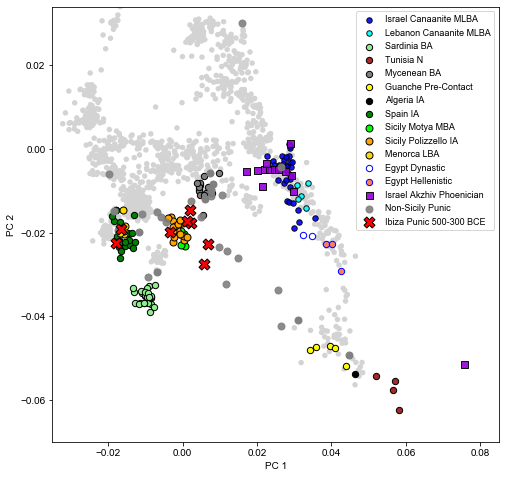

In [40]:
iids_young =  ["I27602", "I27619", "I27620",
               "I27618", "I27610", "I27614",
               "I27613", "I27617"]  # ", "VIL004"
plot_pca_sample(iid=iids_young, savepath="", label="Ibiza Punic 500-300 BCE") 

# Highlight Consanguineous Individuals

I24041|I24190|I24045|I24196|I24193 IIDs: 4/2119
I22121|I22119|I21964 IIDs: 3/2119
I18199|I18201|I18203 IIDs: 3/2119


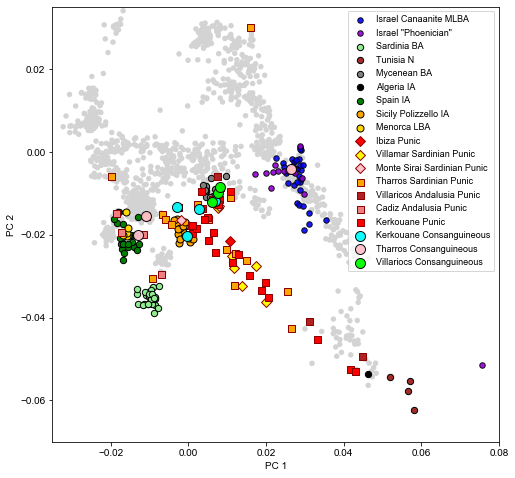

In [41]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
iid = "I24041|I24190|I24045|I24196|I24193"
iid2 = "I22121|I22119|I21964"
iid3 = "I18199|I18201|I18203"
savepath=f"./figures/pca.v45/consagnuineous_pca.pdf"
savepath=""

df_iid = get_sub_iid(df, [iid])
df_iid2 = get_sub_iid(df, [iid2])
df_iid3 = get_sub_iid(df, [iid3])

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")


plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_iid, c="cyan", legend=f"Kerkouane Consanguineous", ec="k", alpha=0.95, s=100)
plot_pca(ax, df_iid2, c="pink", legend=f"Tharros Consanguineous", ec="k", alpha=0.95, s=100)
plot_pca(ax, df_iid3, c="lime", legend=f"Villariocs Consanguineous", ec="k", alpha=0.95, s=100)

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot single individual

I12847|I24213 IIDs: 2/2042


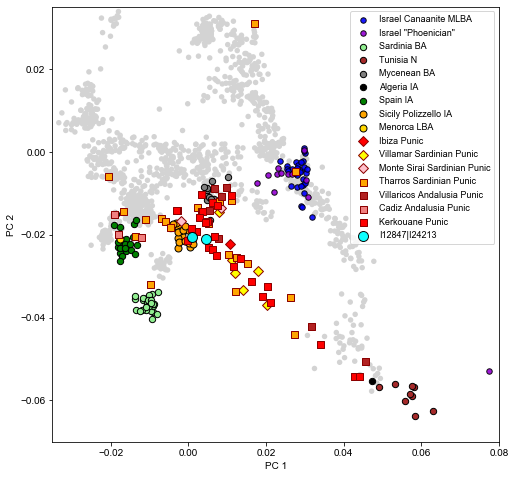

In [30]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
iid = "I12847|I24213"  ### Tunisia - Sicilly relative!
#iid = "I22122|I22118|I22117"  # Relatives Tharros
#iid = "I22122"
#savepath=f"./figures/pca.v45/kerkouane_ROH_pca.pdf"
savepath=""

df_iid = get_sub_iid(df, [iid])

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")


plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_iid, c="cyan", legend=f"{iid}", ec="k", alpha=0.95, s=100)



ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [ ]:
df_vill.sort_values(by="pc2")

In [ ]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
iid = "I22121"
#savepath=f"./figures/pca.v45/kerkouane_ROH_pca.pdf"
savepath=""

df_iid = get_sub_iid(df, [iid])

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")



plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_iid, c="cyan", legend=f"{iid}", ec="k", alpha=0.95, s=100)

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [ ]:
df_kerk.sort_values(by="pc2")

# Sicilian Punic

### Sicilly by Site

# Plot context

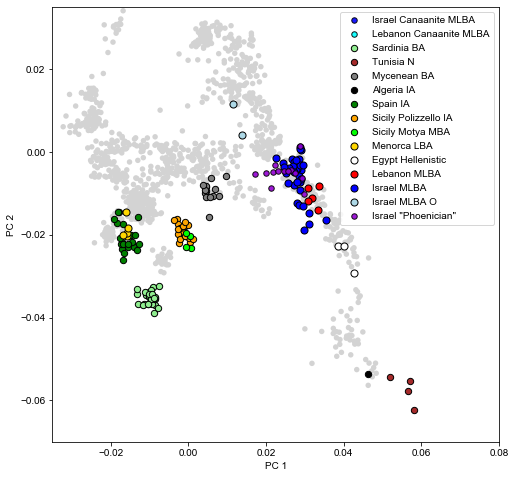

In [21]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath="./figures/pca/west_med_context.png"
savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)

### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")
plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=40, ec="k")
plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=50, marker="o")

plot_pca(ax, df_eg_hell, c="white", legend="Egypt Hellenistic", ec="k", s=50, marker="o")

plot_pca(ax, df_le, c="red", legend="Lebanon MLBA", ec="k", s=50, marker="o")

plot_pca(ax, df_is, c="blue", legend="Israel MLBA", ec="k", s=50, marker="o")
plot_pca(ax, df_is_o, c="lightblue", legend="Israel MLBA O", ec="k", s=50, marker="o")


plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)

#df_is = get_sub_pops_exact(df, pop_list=["Israel_MLBA"])
#df_le = get_sub_pops_exact(df, pop_list=["Lebanon_MBA.SG"])

#plot_pca(ax, df_sic, c="w", legend="Sicilly Punic", ec="blue", s=70, marker="s")
#plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker="s")
#plot_pca(ax, df_sic_him, c="red", legend="Sicily Himera", s=90, marker="o", ec="k")

#plot_pca(ax, df_sic, c="k", legend="Sicilly Punic", ec="blue", s=70, marker=">")
#plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker=">")

ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot Levantine Populations

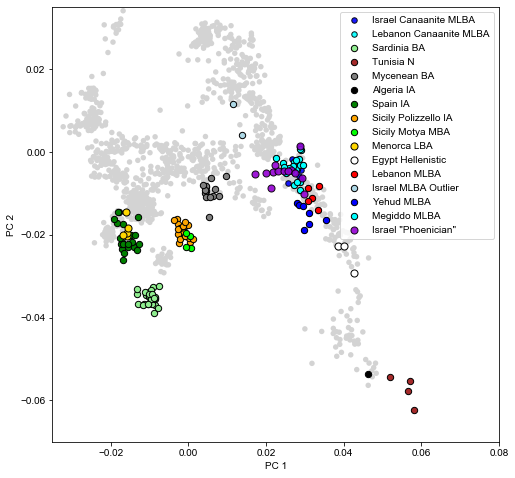

In [32]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath="./figures/pca/west_med_context.png"
savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)

### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")
plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=40, ec="k")
plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=50, marker="o")

plot_pca(ax, df_eg_hell, c="white", legend="Egypt Hellenistic", ec="k", s=50, marker="o")

plot_pca(ax, df_le, c="red", legend="Lebanon MLBA", ec="k", s=40, marker="o")

plot_pca(ax, df_is_o, c="lightblue", legend="Israel MLBA Outlier", ec="k", s=40, marker="o")


df_yehud = df_is[df_is["loc"].str.contains("Yehud")]
df_megiddo = df_is[df_is["loc"].str.contains("Megiddo, Jezreel Valley")]
plot_pca(ax, df_yehud, c="blue", legend="Yehud MLBA", ec="k", s=40, marker="o")
plot_pca(ax, df_megiddo, c="cyan", legend="Megiddo MLBA", ec="k", s=40, marker="o")


plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9, s=50)


ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [14]:
df_is.sort_values(by="pc2")

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact
812,I6924,-0.029885,-0.018840,0.003188,0.014808,Israel_MLBA,I6924,Yehud,21213.0,0.017678,M,3725.0,"Pinhasi, Ron"
804,I6928,-0.031161,-0.017421,-0.006634,0.023306,Israel_MLBA,I6928,Yehud,23573.0,0.019644,M,3725.0,"Pinhasi, Ron"
796,I7002,-0.035494,-0.016408,-0.002884,0.013027,Israel_MLBA,I7002,Yehud,26129.0,0.021774,F,3725.0,"Pinhasi, Ron"
728,I7182,-0.031118,-0.014678,0.002189,0.014668,Israel_MLBA,I7182,Yehud,60690.0,0.050575,M,3725.0,"Pinhasi, Ron"
792,I6922,-0.029609,-0.012963,-0.003942,0.001569,Israel_MLBA,I6922,Yehud,28047.0,0.023373,F,3725.0,"Pinhasi, Ron"
683,I6923,-0.028481,-0.012743,0.001776,0.015386,Israel_MLBA,I6923,Yehud,99327.0,0.082772,M,3725.0,"Pinhasi, Ron"
653,I7003,-0.028124,-0.012355,0.005304,-0.007298,Israel_MLBA,I7003,Yehud,129744.0,0.108120,M,3725.0,"Pinhasi, Ron"
331,I10093,-0.028812,-0.009116,0.001879,0.018347,Israel_MLBA,I10093,"Megiddo, Jezreel Valley",655048.0,0.545873,M,3750.0,"Carmel, Liran"
456,I10097,-0.027124,-0.008073,0.004910,-0.004413,Israel_MLBA,I10097,"Megiddo, Jezreel Valley",447072.0,0.372560,F,3500.0,"Carmel, Liran"
691,I1934,-0.025725,-0.007429,-0.004780,-0.006492,Israel_MLBA,I1934,Tel Shadud,90724.0,0.075603,M,3200.0,"van den Brink, Edwin"


# PCA of Indivdiuals with African Ancestry

In [13]:
### Play with pulling out sample
df[df["pop"].str.contains("Africa")]["pop"].value_counts()

Italy_Sardinia_Punic_oNAfrica          4
Italy_Sicily_unknown_oAfrican          2
Spain_Vandal_Visigoth_oAfrican1        2
Spain_Punic_oAfrican2                  2
Italy_Sardinia_C_oAfrican_new          1
Italy_Sicily_LA_Jewish_oHighAfrican    1
Spain_EBA_Africa_all                   1
Italy_Sicily_MBA_oAfrican              1
Spain_Punic_Roman_oAfrican3            1
Spain_Vandal_Visigoth_oAfrican2        1
Spain_BellBeaker_oAfrican              1
Name: pop, dtype: int64

In [19]:
df_alg_IA = get_sub_pops(df, pop_list=["Algeria_IA"])
df_alg_N = get_sub_pops(df, pop_list=["Algeria_N"])
df_ibero_m = get_sub_pops(df, pop_list=["Morocco_Iberomaurusian"])
df_mor_EN = get_sub_pops(df, pop_list=["Morocco_EN"])
df_mor_LN = get_sub_pops(df, pop_list=["Morocco_LN"])
df_sar_afr = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_C_oAfrican_new"])
df_spain_afr = get_sub_pops_exact(df, pop_list=["Spain_BellBeaker_oAfrican"])
df_sicily_afr = get_sub_pops_exact(df, pop_list=["Italy_Sicily_MBA_oAfrican"])

Algeria_IA Found: 1/2054
Algeria_N Found: 1/2054
Morocco_Iberomaurusian Found: 7/2054
Morocco_EN Found: 3/2054
Morocco_LN Found: 3/2054
Found ['Italy_Sardinia_C_oAfrican_new'] (exact): 1/2054
Found ['Spain_BellBeaker_oAfrican'] (exact): 1/2054
Found ['Italy_Sicily_MBA_oAfrican'] (exact): 1/2054


NameError: name 'df_alg_IA' is not defined

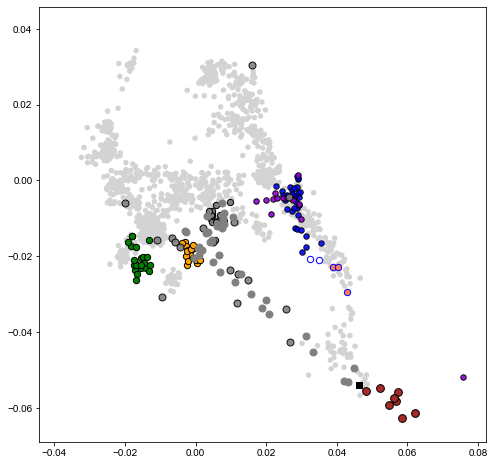

In [20]:
savepath="./figures/pca.v46/pca_afr_punic.png"
savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca(ax, df_ho, c="lightgray")

plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)
plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, marker="s", ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")

### Punic Samples
plot_pca(ax, df_sard, c="gray", legend="Non-Sicily Punic", ec="k", s=49, marker="o", text=False, alpha=0.9)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)
plot_pca(ax, df_vill, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_cad, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)


plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")

plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=60)
plot_pca(ax, df_alg_IA, c="red", legend="Algeria IA", ec="k", s=60)
plot_pca(ax, df_alg_N, c="k", legend="Algeria N", ec="k", s=60)
plot_pca(ax, df_ibero_m, c="cyan", legend="Morocco Iberomaurusian", ec="k", s=60)
plot_pca(ax, df_mor_EN, c="green", legend="Morocco EN", ec="k", s=60)
plot_pca(ax, df_mor_LN, c="lightgreen", legend="Morocco LN", ec="k", s=60)
plot_pca(ax, df_sar_afr, c="yellow", legend="Sardinia C Af. Outlier", ec="k", s=50, marker="D")
plot_pca(ax, df_spain_afr, c="orange", legend="Spain BB Af. Outlier", ec="k", s=50, marker="D")
plot_pca(ax, df_sicily_afr, c="red", legend="Sicily MBA Af. Outlier", ec="k", s=50, marker="D")

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.12])
ax.set_ylim([-0.08,0.03])

plt.show()

# Find close PCA matches

In [ ]:
return_pca_matches(df, iid="I21966")[:50]

In [ ]:
return_pca_matches(df, iid="I18187")[:30]

In [36]:
idx

Int64Index([1952,  934,  149,  955,  948,  153,  954,  953,  947,  604,
            ...
            1457, 1454, 1458,   15,   22,   18, 1693, 1692, 1440, 1439],
           dtype='int64', length=1899)

### Area 51

In [70]:
df_isp

,iid,pc1,pc2,pc3,pc4,pop,Master ID,loc,n_cov_snp,mean_cov,sex,age,contact
344,I22260,-0.022776,-0.005450,0.010605,-0.000180,Israel_Phoenician,I22260,"Akhziv, southern cemetery",611223.0,0.509352,M,2600.0,"Carmel, Liran"
361,I11794,-0.027550,-0.005120,0.009788,-0.003719,Israel_Phoenician,I11794,"Akhziv, northern cemetery",574343.0,0.478619,M,2542.0,"Carmel, Liran"
380,I22252,-0.022019,-0.009662,0.007258,0.004213,Israel_Phoenician,I22252,"Akhziv, southern cemetery",530692.0,0.442243,F,2600.0,"Carmel, Liran"
402,I22254,-0.030238,-0.006774,0.004101,0.002368,Israel_Phoenician,I22254,"Akhziv, southern cemetery",485612.0,0.404677,M,2600.0,"Carmel, Liran"
407,I22257,-0.077418,-0.052938,-0.111019,-0.039409,Israel_Phoenician_o,I22257,"Akhziv, southern cemetery",477079.0,0.397566,F,2600.0,"Carmel, Liran"
479,I22258,-0.020652,-0.005557,0.010253,0.001769,Israel_Phoenician,I22258,"Akhziv, southern cemetery",354955.0,0.295796,F,2600.0,"Carmel, Liran"
488,I22256,-0.023894,-0.005189,0.006876,0.002769,Israel_Phoenician,I22256,"Akhziv, southern cemetery",340362.0,0.283635,F,2600.0,"Carmel, Liran"
502,I22253,-0.030824,-0.010958,0.000637,0.003598,Israel_Phoenician,I22253,"Akhziv, southern cemetery",318204.0,0.265170,M,2600.0,"Carmel, Liran"
524,I11788,-0.025570,-0.005443,0.004063,0.010316,Israel_Phoenician,I11788,"Akhziv, northern cemetery",279026.0,0.232522,M,2600.0,"Carmel, Liran"
563,I11805,-0.023126,-0.003942,0.005026,0.005051,Israel_Phoenician,I11805,"Akhziv, southern cemetery",197411.0,0.164509,M,2600.0,"Carmel, Liran"


In [23]:
df["iid"][df["iid"].str.contains("I22118")]

1956    I22118
Name: iid, dtype: object

In [ ]:
df1 = df[df["pop"].str.contains("Sic")]
df1["pop"].value_counts()

In [ ]:
df_sard

In [322]:
base_path = "/n/groups/reich/DAVID/V44/V44.0/v44.0_HO"
ind_path = base_path + ".ind"

df_ho = pd.read_csv(ind_path, delim_whitespace=True, header=None)
df_ho.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ho)} Individuals")

Loaded 32828 Individuals


In [22]:
df_ho[df_ho["iid"].str.contains("I22118")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,n_cov_snp,mean_cov,sex


In [24]:
df_meta[df_meta["iid"].str.contains("I22118")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family,sex
6834,I22118,I22118,39.873496,8.441024,2300.0,Italy,Unpublished,Italy_Sardinia_Punic,0.683903,820684,5.509,True,..,M
13391,I22118_d,I22118,39.873496,8.441024,2300.0,Italy,Unpublished,Italy_Sardinia_Punic,0.267762,321314,0.706,True,..,U


In [ ]:
df_meta